### Cost Benefit Questions

1. How would you rephrase the business problem if your model was optimizing toward _precision_? i.e., How might the model behave differently, and what effect would it have?
2. How would you rephrase the business problem if your model was optimizing toward _recall_?
3. What would the most ideal model look like in this case?


### Visualizing models over variables

In [12]:
%matplotlib inline

In [2]:
import pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../../assets/dataset/flight_delays.csv')
df = df.loc[df.DEP_DEL15.notnull()].copy()

In [3]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,Unnamed: 15
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,900,855,0,NaN
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,900,856,0,NaN
2,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,1230,1226,0,NaN
3,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,1220,1214,0,NaN
4,1,4,2015-01-01,AA,19805,AA,11298,1129803,30194,12173,1217302,32134,1305,1754,1,NaN


In [3]:
df = df[df.DEP_DEL15.notnull()]
df = df.join(pd.get_dummies(df['CARRIER'], prefix='carrier'))
df = df.join(pd.get_dummies(df['DAY_OF_WEEK'], prefix='dow'))
model = lm.LogisticRegression()
features = [i for i in df.columns if 'dow_' in i]

In [5]:
df.shape

(458311, 37)

In [6]:
features += ['CRS_DEP_TIME']
model.fit(df[features[1:]], df['DEP_DEL15'])

df['probability'] = model.predict_proba(df[features[1:]]).T[1]

In [9]:
model.predict_proba(df[features[1:]]).T[1]

array([ 0.1291925 ,  0.1291925 ,  0.15810182, ...,  0.13215362,
        0.13588357,  0.14099443])

In [11]:
print df.head()

   DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE UNIQUE_CARRIER  AIRLINE_ID CARRIER  \
0             1            4  2015-01-01             AA       19805      AA   
1             1            4  2015-01-01             AA       19805      AA   
2             1            4  2015-01-01             AA       19805      AA   
3             1            4  2015-01-01             AA       19805      AA   
4             1            4  2015-01-01             AA       19805      AA   

   ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID  ORIGIN_CITY_MARKET_ID  \
0              12478                1247802                  31703   
1              12892                1289203                  32575   
2              12478                1247802                  31703   
3              12892                1289203                  32575   
4              11298                1129803                  30194   

   DEST_AIRPORT_ID     ...       carrier_VX  carrier_WN  dow_1  dow_2  dow_3  \
0            12892     .

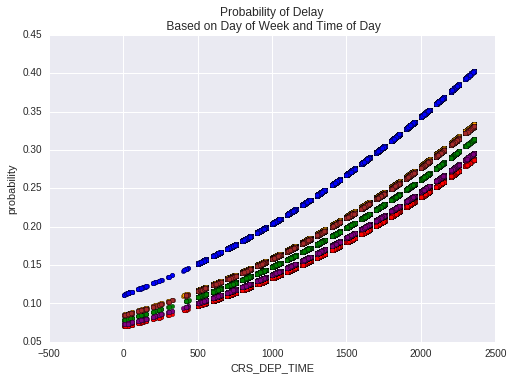

In [12]:
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
for e, c in enumerate(colors):
    df[df[features[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', color = c, ax=ax)

ax.set(title='Probability of Delay\n Based on Day of Week and Time of Day')


### Other Answers: visualizing Airline or the inverse

In [17]:
#We already dummy-fied the carrier
features = [i for i in df.columns if 'carrier_' in i]
features += ['CRS_DEP_TIME']

model = lm.LogisticRegression()
model.fit(df[features[1:]],df['DEP_DEL15'])

df['probabilities'] = model.predict_proba(df[features[1:]])[:,1]

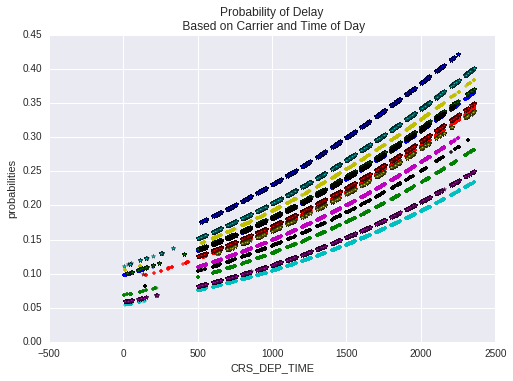

In [32]:
ax = plt.subplot(111)
color_style = ['b+','g+','r+','c+','m+','y+','k+','b*','g*','r*','c*','m*','y*','k*']

for e,cs in enumerate(color_style):
    df[df[features[e]] == 1].plot(x='CRS_DEP_TIME',y='probabilities',color = cs[0],marker = cs[1],kind='scatter',ax=ax)

ax.set(title = 'Probability of Delay\n Based on Carrier and Time of Day')

In [40]:
#Plotting the inverses
df['probabilities_inverse'] = 1-df['probabilities']

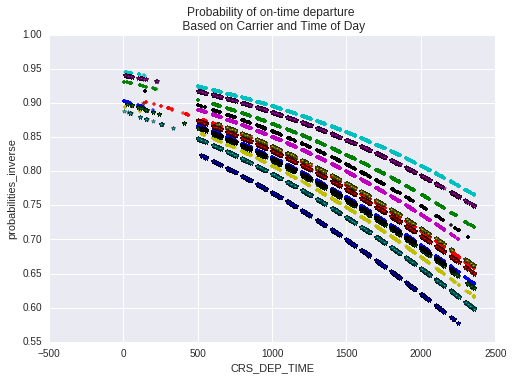

In [42]:
ax = plt.subplot(111)
color_style = ['b+','g+','r+','c+','m+','y+','k+','b*','g*','r*','c*','m*','y*','k*']

for e,cs in enumerate(color_style):
    df[df[features[e]] == 1].plot(x='CRS_DEP_TIME',y='probabilities_inverse',color = cs[0],marker = cs[1],kind='scatter',ax=ax)

ax.set(title = 'Probability of on-time departure \n Based on Carrier and Time of Day')

In [18]:
len(features)

15

### Visualizing Performance Against Baseline

#### Visualizing AUC and comparing Models

In [4]:
from sklearn import dummy, metrics

In [6]:
features = [i for i in df.columns if 'carrier_' in i]
features += ['CRS_DEP_TIME']

In [7]:
model0 = dummy.DummyClassifier()
model0.fit(df[features[1:]], df['DEP_DEL15'])
df['probability_0'] = model0.predict_proba(df[features[1:]]).T[1]

In [9]:
model1 = lm.LogisticRegression()
model.fit(df[features[1:]], df['DEP_DEL15'])
df['probability_1'] = model.predict_proba(df[features[1:]]).T[1]

In [8]:
df['probability_0'].head()

0    0
1    0
2    0
3    0
4    1
Name: probability_0, dtype: int64

In [46]:
df.shape

(458311, 41)

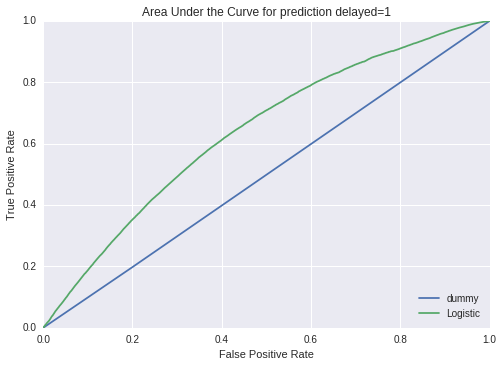

In [49]:
ax = plt.subplot(111)
vals = metrics.roc_curve(df.DEP_DEL15, df.probability_0)
ax.plot(vals[0], vals[1],label = 'dummy')
vals = metrics.roc_curve(df.DEP_DEL15, df.probability_1)
ax.plot(vals[0], vals[1],label = 'Logistic')

ax.set(title='Area Under the Curve for prediction delayed=1', ylabel='True Positive Rate', xlabel='False Positive Rate', xlim=(0, 1), ylim=(0, 1))
ax.legend(loc = 4)

#### Visualizing Precision / Recall

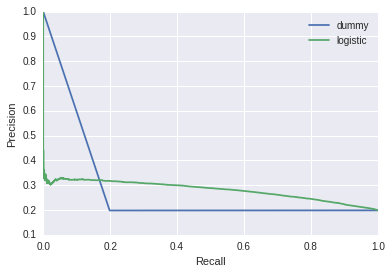

In [21]:
precision_dummy,recall_dummy,thresh = metrics.precision_recall_curve(df['DEP_DEL15'],df['probability_0'])
precision_logistic,recall_logistic,thresh = metrics.precision_recall_curve(df['DEP_DEL15'],df['probability_1'])

plt.plot(recall_dummy,precision_dummy,label = 'dummy')
plt.plot(recall_logistic,precision_logistic,label = 'logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 1)

When the Recall is below .2, the precision of the dummy model is significantly higher than the precision of the logistic model. Though in all fairness, the Recall of the dummy is never less than .2. For any high recall values needed, our logistic model definitely outperforms the dummy.

#### Logistic Precision-Recall

In [44]:
#If we want to be cautious about predictions
probability_pred = df['probability_1']
predictions = (probability_pred >= .5) + 0   #The threshold is given by .8

#Getting the confusion matrix
logistic_confusion = metrics.confusion_matrix(df['DEP_DEL15'],predictions)
logistic_confusion = pd.DataFrame(logistic_confusion,index = ['actual_0','actual_1'],columns = ['pred_0','pred_1'])
print logistic_confusion

precision = float(logistic_confusion.loc['actual_1','pred_1']) / logistic_confusion['pred_1'].sum()
print 'precision = %s' % precision

recall = float(logistic_confusion.loc['actual_1','pred_1']) / logistic_confusion.loc['actual_1',:].sum()
print 'recall = %s' % recall

          pred_0  pred_1
actual_0  367333       0
actual_1   90978       0


ZeroDivisionError: float division by zero

#### Dummy precison-recall

In [39]:
#If we want to be cautious about predictions
probability_pred = df['probability_0']
predictions = (probability_pred >= 1) + 0   #The threshold is given by .8

#Getting the confusion matrix
logistic_confusion = metrics.confusion_matrix(df['DEP_DEL15'],predictions)
logistic_confusion = pd.DataFrame(logistic_confusion,index = ['actual_0','actual_1'],columns = ['pred_0','pred_1'])
print logistic_confusion

precision = float(logistic_confusion.loc['actual_1','pred_1']) / logistic_confusion['pred_1'].sum()
print 'precision = %s' % precision

recall = float(logistic_confusion.loc['actual_1','pred_1']) / logistic_confusion.loc['actual_1',:].sum()
print 'recall = %s' % recall

          pred_0  pred_1
actual_0  294246   73087
actual_1   72924   18054
precision = 0.198088675788
recall = 0.198443579767


[[294246  73087]
 [ 72924  18054]]


ValueError: Can't handle mix of binary and continuous